In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

import torch
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from torch import nn
import torch.nn.functional as F

from causal_util import load_env
from causal_util.collect_data import EnvDataCollector
from matplotlib import pyplot as plt
from keychest.keychestenv import keychest_obs3d_to_obs2d, keychest_obs2d_to_image
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
import pickle as pickle
from causal_util.helpers import one_hot_encode
import gin
from keychest.features_xy import obs_features_handcoded, arr_to_dict, dict_to_arr
import io

In [4]:
ckpt = '/home/sergei/ray_results/5x5_decoder_kc_siamese_l2/main_fcn_22eb1_00000_0_2021-01-26_07-10-06/checkpoint_1000/checkpoint'

In [5]:
# https://github.com/pytorch/pytorch/issues/16797
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [6]:
with open(ckpt, 'rb') as f:
    learner = CPU_Unpickler(f).load()#pickle.load(f)

2021-01-26 07:33:40,766	INFO worker.py:651 -- Connecting to existing Ray cluster at address: 172.26.78.149:6379


Selecting name 6ddd9406-5fa0-11eb-a94e-03a7e0fad0cd
Make environment KeyChest-v0 None {}


In [7]:
env = learner.env
h, w, c = env.engine._observation.shape

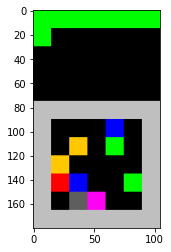

In [8]:
obs = env.reset()
obs = obs.reshape(h, w, c)
plt.imshow(keychest_obs2d_to_image(keychest_obs3d_to_obs2d(obs)))
plt.show()

In [9]:
learner.decoder(torch.tensor(np.random.randn(1, 924), dtype=torch.float32).to(learner.device))

tensor([[ 0.3975, -0.8157, -2.2450, -2.0336,  0.5645,  0.0850, -1.4156, -1.5003,
         -0.7025,  0.4514, -0.9714,  0.9169, -1.2650,  0.0969, -3.5613, -1.6538,
          0.5325,  2.2952, -0.8494,  0.7373]], grad_fn=<AddmmBackward>)

In [10]:
learner.collect_steps()

# Feature attribution

#### Distribution of latent variables

In [11]:
learner.collect_steps()

In [12]:
obs_x_batch = learner._context['obs_x']

In [13]:
obs_dec = learner.decoder(obs_x_batch).detach().cpu().numpy()

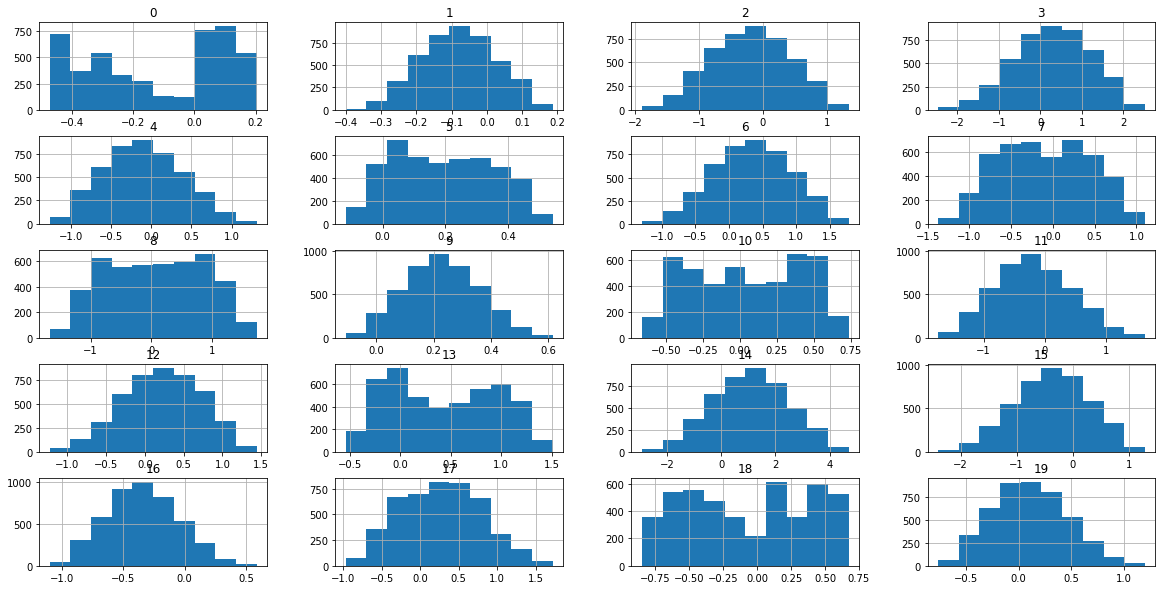

In [14]:
df = pd.DataFrame(obs_dec)
_ = df.hist(figsize=(20, 10))

#### ranges for latent variables

In [15]:
n_latent = obs_dec.shape[1]

In [16]:
latent_min_max = list(zip(np.min(obs_dec, axis=0), np.max(obs_dec, axis=0)))

In [17]:
obs_channels = learner.normalizers['obs'].unnormalize(obs_x_batch.numpy()).reshape(-1, h, w, c)

In [18]:
f_x = [obs_features_handcoded(learner.env.engine, obs_c) for obs_c in obs_channels]

In [19]:
keys = sorted(f_x[0].keys())

In [20]:
f_x_arr = np.array([dict_to_arr(f) for f in f_x])

In [21]:
df = pd.DataFrame()
feature_names = []
for f_id in range(obs_dec.shape[1]):
    fn = "feature_%03d" % f_id
    feature_names.append(fn)
    df[fn] = obs_dec[:, f_id]
for i, k in enumerate(keys):
    df[k] = f_x_arr[:, i]

In [22]:
df

,feature_000,feature_001,feature_002,feature_003,feature_004,feature_005,feature_006,feature_007,feature_008,feature_009,...,key__01__x,key__01__y,keys,lamp_off__x,lamp_off__y,lamp_on__x,lamp_on__y,lamp_status,player__x,player__y
0,-0.299875,-0.039764,0.388294,0.769276,0.144914,0.235306,0.352383,0.808144,-0.572558,0.236531,...,10.0,3.0,0.0,8.0,3.0,-1.0,-1.0,0.0,8.0,4.0
1,-0.447026,0.047430,0.732700,0.578107,0.083797,0.360629,0.816998,0.593199,0.272973,0.211104,...,10.0,3.0,0.0,8.0,3.0,-1.0,-1.0,0.0,8.0,5.0
2,-0.408340,0.096456,0.791910,0.656580,-0.268133,0.328799,1.184135,0.077084,1.041720,0.126893,...,10.0,3.0,0.0,8.0,3.0,-1.0,-1.0,0.0,7.0,5.0
3,-0.214794,0.072495,0.548220,1.004755,-0.696938,0.189779,1.287142,-0.410171,1.425655,0.039469,...,10.0,3.0,0.0,8.0,3.0,-1.0,-1.0,0.0,7.0,4.0
4,0.054466,-0.014249,0.067488,1.333354,-0.919849,0.011024,0.987865,-0.625852,1.075893,0.024046,...,10.0,3.0,0.0,8.0,3.0,-1.0,-1.0,0.0,6.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4587,-0.193233,-0.018474,-0.021328,0.014939,-0.310371,0.247141,0.796569,-0.656382,1.095189,0.166466,...,10.0,5.0,0.0,10.0,4.0,-1.0,-1.0,0.0,7.0,4.0
4588,0.075501,-0.107328,-0.500381,0.352689,-0.537180,0.067848,0.494616,-0.871633,0.740936,0.150260,...,10.0,5.0,0.0,10.0,4.0,-1.0,-1.0,0.0,6.0,4.0
4589,0.167686,-0.174312,-0.827884,0.514721,-0.419557,0.013555,0.075937,-0.595134,0.019608,0.200600,...,10.0,5.0,0.0,10.0,4.0,-1.0,-1.0,0.0,6.0,4.0
4590,0.132070,-0.205654,-0.929888,0.473334,-0.151986,0.070996,-0.232053,-0.165275,-0.616951,0.269565,...,10.0,5.0,0.0,10.0,4.0,-1.0,-1.0,0.0,7.0,4.0


<AxesSubplot:>

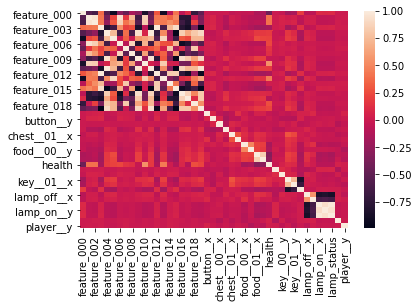

In [23]:
sns.heatmap(df.corr())

<AxesSubplot:>

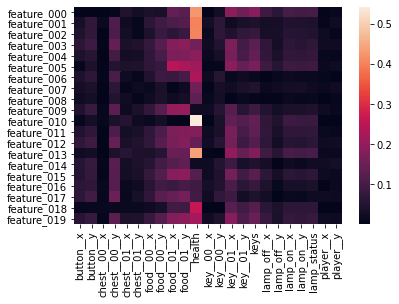

In [24]:
sns.heatmap(np.abs(df.corr().loc[feature_names, keys]))

<AxesSubplot:>

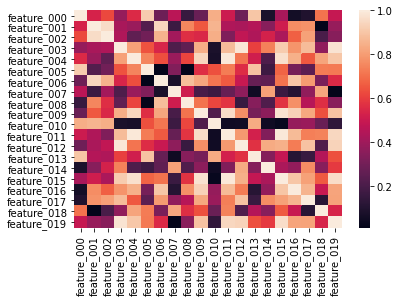

In [25]:
sns.heatmap(np.abs(df.loc[:, feature_names].corr()))

<AxesSubplot:>

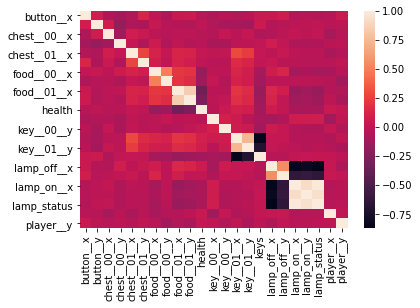

In [26]:
sns.heatmap(df.loc[:, keys].corr())